# Distributed MNIST with MLX and Kubeflow Trainer

This Notebook will show how to run distributed MLX on Kubernetes with Kubeflow Trainer.

We will use the MLX Runtime to created distributed training using OpenMPI and local minikube cluster.

MLX Distributed: https://ml-explore.github.io/mlx/build/html/usage/distributed.html

Minikube: https://minikube.sigs.k8s.io/docs/



## (Optional) Create minikube cluster with shared volume

This notebook exports the trained model to your local volume for evaluation.

To do this, follow these steps:

Create a Minikube cluster with a mounted path. The `mlx-model` folder needs to be accessible by the `mpiuser`:

```sh
mkdir mlx-model
chmod 777 mlx-model
minikube start --driver=podman --cpus=8 --mount --mount-string="$(pwd):/mnt/data"
```

After that you can patch the ClusterTrainingRuntime using the following command:

```yaml
kubectl patch clustertrainingruntime mlx-distributed --type='json' -p='[
  {
    "op": "add",
    "path": "/spec/template/spec/replicatedJobs/0/template/spec/template/spec/containers/0/volumeMounts",
    "value": [
      {
        "name": "mlx-model",
        "mountPath": "/home/mpiuser/mlx-model"
      }
    ]
  },
  {
    "op": "add",
    "path": "/spec/template/spec/replicatedJobs/0/template/spec/template/spec/volumes",
    "value": [
      {
        "name": "mlx-model",
        "hostPath": {
          "path": "/mnt/data/mlx-model"
        }
      }
    ]
  }
]'
```

## Create MLX training script

We need to wrap our training script into a function to create Kubeflow TrainJob.

This is the simple MLP model to recognize digits from the MNIST dataset.

In [2]:
def mlx_train_mnist(args):
    import time
    from functools import partial
    import mlx.core as mx
    import mlx.nn as nn
    import mlx.optimizers as optim
    from mlx.data.datasets import load_mnist

    # Define a simple MLP model with MLX.
    class MLP(nn.Module):
        def __init__(
            self, in_dims: int, hidden_dims: int, num_layers: int, out_dims: int
        ):
            super().__init__()
            layer_sizes = [in_dims] + [hidden_dims] * num_layers + [out_dims]
            self.layers = [
                nn.Linear(idim, odim)
                for idim, odim in zip(layer_sizes[:-1], layer_sizes[1:])
            ]

        def __call__(self, x):
            for layer in self.layers[:-1]:
                x = nn.relu(layer(x))
            return self.layers[-1](x)

    # Try to initialize MLX distributed, otherwise run code in non-distributed.
    try:
        dist = mx.distributed.init(strict=True, backend="mpi")
        world_size = dist.size()
        rank = dist.rank()
        print(f"Start Distributed Training, WORLD_SIZE: {world_size}, RANK: {rank}")
    except Exception:
        world_size = 1
        rank = 0
        print("Start non-Distributed Training")

    # Load MNIST dataset and partition it.
    BATCH_SIZE = 128
    train_dataset = load_mnist()
    distributed_ds = (
        train_dataset.shuffle()
        .partition_if(world_size > 1, world_size, rank)
        .key_transform("image", lambda x: x / 255.0)
    )

    # Create the MLP model and SGD optimizer
    model = MLP(
        in_dims=train_dataset[0]["image"].shape[-1],
        hidden_dims=32,
        num_layers=2,
        out_dims=10,
    )
    optimizer = optim.SGD(learning_rate=0.01)

    # Define function to calculate loss and accuracy.
    def loss_fn(model, x, y):
        output = model(x)
        loss = mx.mean(nn.losses.cross_entropy(output, y))
        acc = mx.mean(mx.argmax(output, axis=1) == y)
        return loss, acc

    # Define single training step.
    @partial(mx.compile, inputs=model.state, outputs=model.state)
    def step(x, y):
        loss_and_grad_fn = nn.value_and_grad(model, loss_fn)
        (loss, acc), grads = loss_and_grad_fn(model, x, y)
        # Average grads to aggregate them across distributed nodes.
        grads = nn.utils.average_gradients(grads)
        optimizer.update(model, grads)
        return loss, acc

    # Average statistic across distributed nodes.
    def average_stats(stats, count):
        with mx.stream(mx.cpu):
            stats = mx.distributed.all_sum(mx.array(stats))
            count = mx.distributed.all_sum(count)
            return (stats / count).tolist()

    # Start distributed training.
    for epoch in range(10):
        epoch_start = time.perf_counter()
        losses = accuracies = count = 0

        for batch_idx, batch_sample in enumerate(distributed_ds.batch(BATCH_SIZE)):
            x = mx.array(batch_sample["image"])
            y = mx.array(batch_sample["label"])
            loss, acc = step(x, y)
            mx.eval(loss, acc, model.state)

            losses += loss.item()
            accuracies += acc.item()
            count += 1

            # Print the results.
            if batch_idx % 10 == 0:
                loss, acc = average_stats([losses, accuracies],count)
                if rank == 0:
                    print(
                        "Epoch: {} [{}/{} ({:.0f}%)] \tTrain loss: {:.3f}, acc: {:.3f}".format(
                            epoch,
                            batch_idx * len(x),
                            len(train_dataset),
                            100.0 * batch_idx * len(x) / len(train_dataset),
                            loss,
                            acc,
                        )
                    )
        if rank == 0:
            print(
                "Epoch: {}, time: {:.2f} seconds\n\n".format(
                    epoch, time.perf_counter() - epoch_start
                )
            )
    if rank == 0: 
        # Finally, save the trained model to the disk.    
        model.save_weights(args["MODEL_PATH"])

## List Available Kubeflow Trainer Runtimes


Get available Kubeflow Trainer Runtimes with the `list_runtimes()` API.

You can inspect Runtime details, including the name, framework, entry point, and number of accelerators.

- Runtimes with **CustomTrainer**: You must write the training script within the function.

- Runtimes with **BuiltinTrainer**: You can configure settings (e.g., LoRA Config) for LLM fine-tuning Job.


In [3]:
from kubeflow.trainer import TrainerClient, CustomTrainer

for r in TrainerClient().list_runtimes():
    print(f"Name: {r.name}, Framework: {r.trainer.framework.value}, Trainer Type: {r.trainer.trainer_type.value}\n")
    print(f"Entrypoint: {r.trainer.entrypoint[:3]}\n")

    if r.name == "mlx-distributed":
        mlx_runtime = r

Name: mlx-distributed, Framework: mlx, Trainer Type: CustomTrainer

Entrypoint: ['mpirun', '--hostfile', '/etc/mpi/hostfile']



## Create TrainJob for Distributed Training

Use the `train()` API to create distributed TrainJob on 2 MPI Nodes.

In [4]:
# The `mlx-model` folder must be created.
MODEL_PATH = "mlx-model/model.npz"
args = {
    "MODEL_PATH": MODEL_PATH
}

job_id = TrainerClient().train(
    trainer=CustomTrainer(
        func=mlx_train_mnist,
        func_args=args,
        num_nodes=3,
    ),
    runtime=mlx_runtime,
)

In [5]:
# Train API generates a random TrainJob id.
job_id

'da21320a957a'

## Check the TrainJob Info

Use the `list_jobs()` and `get_job()` APIs to get information about created TrainJob and its steps.

In [6]:
for job in TrainerClient().list_jobs():
    print(f"TrainJob: {job.name}, Status: {job.status}, Created at: {job.creation_timestamp}")

TrainJob: da21320a957a, Status: Created, Created at: 2025-03-24 00:29:40+00:00
TrainJob: sc3e8e77ce2b, Status: Succeeded, Created at: 2025-03-24 00:26:11+00:00


In [7]:
# We execute mpirun command on node-0, which functions as the MPI Launcher node.
for c in TrainerClient().get_job(name=job_id).steps:
    print(f"Step: {c.name}, Status: {c.status}, Devices: {c.device} x {c.device_count}\n")

Step: node-0, Status: Running, Devices: cpu x 2

Step: node-1, Status: Running, Devices: cpu x 2

Step: node-2, Status: Running, Devices: cpu x 2



## Get the TrainJob Logs

Use the `get_job_logs()` API to retrieve the TrainJob logs.

Since we distribute the dataset across 3 nodes, each rank processes `round(60,000 / 3) = 20,000` samples.

In [8]:
_ = TrainerClient().get_job_logs(name=job_id, follow=True)

[node-0]: Warning: Permanently added '[da21320a957a-node-0-1.da21320a957a]:2222' (ECDSA) to the list of known hosts.
[node-0]: Warning: Permanently added '[da21320a957a-node-0-0.da21320a957a]:2222' (ECDSA) to the list of known hosts.
[node-0]: --------------------------------------------------------------------------
[node-0]: PMIx was unable to find a usable compression library
[node-0]: on the system. We will therefore be unable to compress
[node-0]: large data streams. This may result in longer-than-normal
[node-0]: startup times and larger memory footprints. We will
[node-0]: continue, but strongly recommend installing zlib or
[node-0]: a comparable compression library for better user experience.
[node-0]: You can suppress this warning by adding "pcompress_base_silence_warning=1"
[node-0]: to your PMIx MCA default parameter file, or by adding
[node-0]: "PMIX_MCA_pcompress_base_silence_warning=1" to your environment.
[node-0]: --------------------------------------------------------

## Evaluate the Trained Model

Since the volume is shared between the Minikube cluster and the local directory, you can evaluate the trained model directly.

We will use test images from the MNIST dataset for prediction.

- <span style="color:green">Green label</span> indicate correct predictions.
- <span style="color:red">Red label</span> indicate incorrect predictions, with the correct value shown in parentheses.

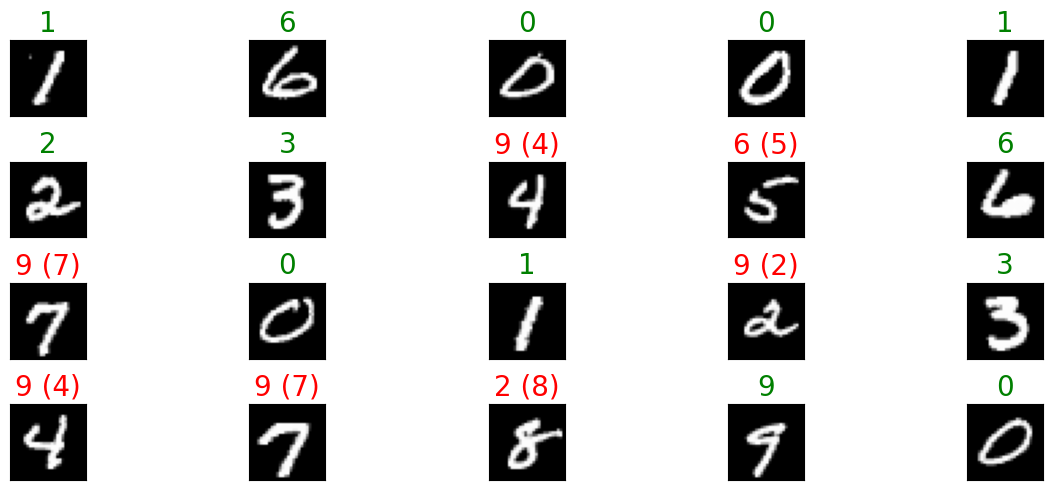

In [9]:
import mlx.core as mx
import mlx.nn as nn
import matplotlib.pyplot as plt
from mlx.data.datasets import load_mnist


# Load test dataset and take the random batch from it.
test_batch = (
    load_mnist(train=False)
    .key_transform("image", lambda x: x / 255.0)
    .batch(20)[mx.random.randint(10, 500)]
)

class MLP(nn.Module):
    def __init__(self, in_dims: int, hidden_dims: int, num_layers: int, out_dims: int):
        super().__init__()
        layer_sizes = [in_dims] + [hidden_dims] * num_layers + [out_dims]
        self.layers = [
            nn.Linear(idim, odim)
            for idim, odim in zip(layer_sizes[:-1], layer_sizes[1:])
        ]

    def __call__(self, x):
        for layer in self.layers[:-1]:
            x = nn.relu(layer(x))
        return self.layers[-1](x)

# Load weights from the trained model.
model = MLP(
    in_dims=test_batch["image"][0].shape[-1],
    hidden_dims=32,
    num_layers=2,
    out_dims=10,
).load_weights(MODEL_PATH)

# Send test batch to the pre-trained MLP model.
x = mx.array(test_batch["image"])
output = model(x)
fig = plt.figure(figsize=(15, 5))
for i in range(20):
    # Format the input image and the model output.
    image = test_batch["image"][i].reshape((28, 28))
    pred_label = mx.argmax(output[i])

    # Add data to the plot.
    ax = fig.add_subplot(4, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(image, cmap="gray")
    if test_batch["label"][i] == pred_label:
        ax.set_title(test_batch["label"][i], color="green")
    else:
        ax.set_title("{} ({})".format(pred_label, test_batch["label"][i]), color="red")

    ax.title.set_fontsize(20)
    fig.tight_layout()
